Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
step size after loading Parameter containing:
tensor([2.4346, 2.1761, 2.0759, 2.0074, 1.9537, 1.9088, 1.8730, 1.8683, 1.8647,
        1.8965, 1.6054, 1.6757, 2.3449, 2.1816, 1.8889, 2.2923, 2.7119, 2.0788,
        1.7842, 2.7531, 2.1476, 2.5858, 2.1847, 3.1431, 3.5477, 2.7290, 1.9660,
        1.0813, 0.6090, 0.3123, 0.7020, 0.2085, 1.4898, 0.2137, 3.0474, 0.2646,
        1.1321, 0.4024, 0.1986, 1.5816], requires_grad=True)
Execution time for unfolded model: 0.7624683380126953 seconds
tensor(-3.4293)
Execution time for classical model: 7.373667001724243 seconds
tensor(-3.0926)
tensor([3.5348, 2.2312, 3.3076, 3.1600, 3.1839, 1.9300, 2.1565, 3.7943, 3.5990,
        2.7091, 2.5729, 3.4592, 2.7719, 2.9640, 3.6685, 2.9852, 2.7724, 3.5252,
        2.8615, 4.2057, 2.8517, 3.1354, 3.0392, 2.8088, 3.5551, 2.2994, 3.4201,
        3.0996, 2.2151, 3.3937, 3.7505, 3.3682, 

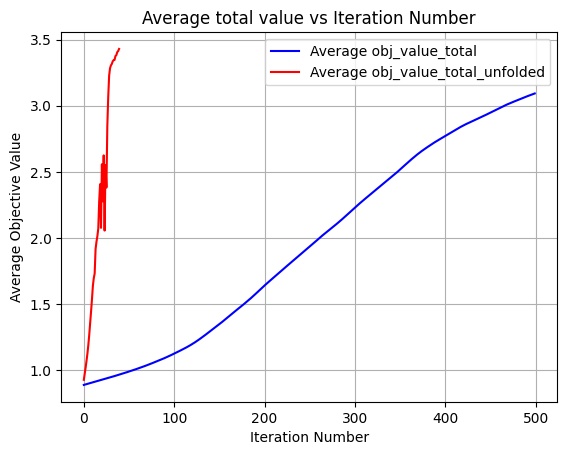

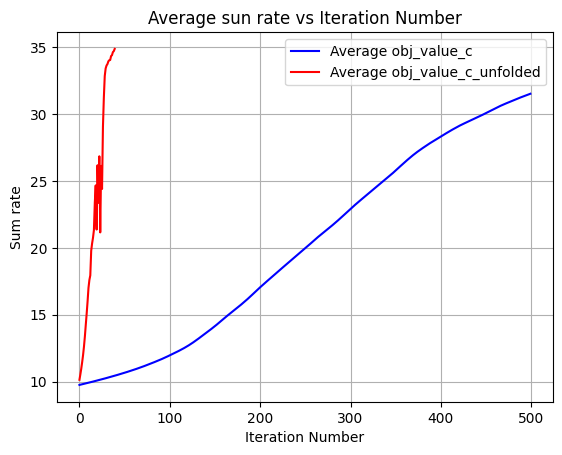

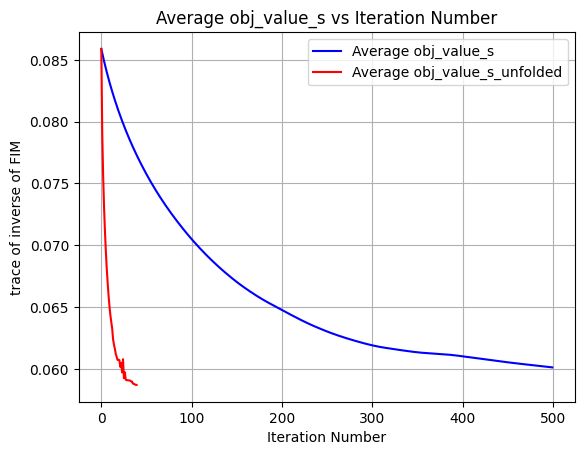

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.io import savemat
torch.autograd.set_detect_anomaly(True)

from google.colab import drive
drive.mount('/content/drive')

class PGA_Net(nn.Module):

  def __init__(self, hyp, device):
    super(PGA_Net, self).__init__()
    self.hyp = nn.Parameter(hyp)
    self.device = device


  def forward(self, h, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha, theta, phi, upa_set, num_iter):
    # projection gradient ascent algorithm for sum rate problem

    # input:
    # h -- given the communications channels for all users and all channel realizations
    # h should be a tensor whose dimension are
    # [channel realizations, number of transmit antannas, number of communications users]
    # noise_c and noise_s -- noise of sensing and communications parts
    # lents -- length of time slots
    # delta_s and delta_c -- weight coefficients for sensing and communications components
    # alpha -- radar cross-section
    # theta -- azimuth angles
    # phi -- elevation angles
    # num_iter number of iterations

    ## obtaining system parameters


    # test_size, num_tx, num_users = h.shape
    # num_sensing_streams = 0

    # num_targets = alpha.shape[-1]
    # nth, ntv, nrh, nrv = upa_set

    # A, dAtheta, dAphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nth, ntv, self.device)
    # B, dBtheta, dBphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nrh, nrv, self.device)

    # U = torch.diag_embed(alpha)

    # ## precompute some matrices for calculating FIM
    # U_AH = torch.bmm(U, A.conj().transpose(1, 2))  # U * A^H
    # dAtheta_UH = torch.bmm(dAtheta, U.conj().transpose(1, 2)) # U * dAtheta^H
    # dAphi_UH = torch.bmm(dAphi, U.conj().transpose(1, 2)) # U * dAphi^H

    # BH_B = torch.bmm(B.conj().transpose(1, 2), B)
    # dBthetaH_dBtheta = torch.bmm(dBtheta.conj().transpose(1, 2), dBtheta)
    # dBphiH_dBphi = torch.bmm(dBphi.conj().transpose(1, 2), dBphi)

    # BH_dBtheta = torch.bmm(B.conj().transpose(1, 2), dBtheta)
    # BH_dBphi = torch.bmm(B.conj().transpose(1, 2), dBphi)
    # dBthetaH_dBphi = torch.bmm(dBtheta.conj().transpose(1, 2), dBphi)


    # ## initialize variables
    # w_c = h.clone().detach()
    # # w_s = eigvector.unsqueeze(0).unsqueeze(-1)
    # # w_s = w_s.expand(test_size, num_tx, num_sensing_streams)
    # w_s = torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)+1j*torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)
    # w = torch.cat((w_c, w_s), dim=-1)
    # w = torch.sqrt(pt)* w / torch.linalg.norm(w, ord='fro',dim=(-2,-1), keepdim = True)
    test_size, num_tx, num_users = h.shape
    num_sensing_streams = 0

    num_targets = alpha.shape[-1]
    nth, ntv, nrh, nrv = upa_set

    A, dAtheta, dAphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nth, ntv, self.device)
    B, dBtheta, dBphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nrh, nrv, self.device)

    U = torch.diag_embed(alpha)

    ## precompute some matrices for calculating FIM
    U_AH = torch.bmm(U, A.conj().transpose(1, 2))  # U * A^H
    dAtheta_UH = torch.bmm(dAtheta, U.conj().transpose(1, 2)) # U * dAtheta^H
    dAphi_UH = torch.bmm(dAphi, U.conj().transpose(1, 2)) # U * dAphi^H

    BH_B = torch.bmm(B.conj().transpose(1, 2), B)
    dBthetaH_dBtheta = torch.bmm(dBtheta.conj().transpose(1, 2), dBtheta)
    dBphiH_dBphi = torch.bmm(dBphi.conj().transpose(1, 2), dBphi)

    BH_dBtheta = torch.bmm(B.conj().transpose(1, 2), dBtheta)
    BH_dBphi = torch.bmm(B.conj().transpose(1, 2), dBphi)
    dBthetaH_dBphi = torch.bmm(dBtheta.conj().transpose(1, 2), dBphi)



    ## initialize variables
    w_c = h.clone().detach()
    w_s = torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)+1j*torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)
    w = torch.cat((w_c, w_s), dim=-1)
    w = torch.sqrt(pt)* w / torch.linalg.norm(w, ord='fro',dim=(-2,-1), keepdim = True)




    #print( torch.square(torch.linalg.norm(w, ord='fro',dim=(-2,-1), keepdim = True)) )

    ## define a variable to observe the convergence
    obj_total = torch.zeros(test_size, num_iter, device=self.device)
    obj_comm = torch.zeros(test_size, num_iter, device=self.device)
    obj_sens = torch.zeros(test_size, num_iter, device=self.device)

    ## main iteration
    for x in range(num_iter):
      ## update auxilary variables for calculating the gradients
      hw = torch.bmm(h.transpose(-2, -1).conj(), w)
      T_k = torch.sum(self.square_abs(hw), dim=-1)+noise_c
      diag_hw = torch.diagonal(hw, dim1=-2, dim2=-1)

      alpha_k = T_k / (T_k -self.square_abs(diag_hw) )-1
      beta_k = torch.sqrt( 1 + alpha_k ) * diag_hw / T_k

      sigma1 = torch.diag_embed(torch.sqrt(1+alpha_k) * beta_k)
      sigma2 = torch.diag_embed(self.square_abs(beta_k))

      fim_batch = self.calculate_FIM_batch(lents, noise_s, w, A, U_AH, dAtheta_UH, dAphi_UH, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, self.device)

      crb_batch = self.calculate_fim_inverses(fim_batch, self.device)

      phi_auxiliary_batch = torch.bmm(crb_batch, crb_batch)

      q_matrix_batch = self.construct_matrix_q_batch(lents, noise_s, phi_auxiliary_batch, A, U_AH, dAtheta, dAphi, dAtheta_UH, dAphi_UH, U, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, self.device)
      #(lents, noise_s, phi_auxiliary_batch, A, dAtheta, dAphi, B, dBtheta, dBphi, U, self.device)

      linear_term = delta_c * torch.bmm (h, sigma1.to(torch.complex64))
      linear_term = torch.cat(( linear_term,torch.zeros_like(w_s)), dim=-1)

      h_sigma = torch.bmm(h, sigma2.to(torch.complex64))

      quadratic_term = 0.5 * delta_s * q_matrix_batch - delta_c * torch.bmm(h_sigma, h.transpose(-2,-1).conj())


      gradient_w =linear_term + torch.bmm(quadratic_term, w)
      w = w + self.hyp[x] * gradient_w
      w = torch.sqrt(pt) * w / torch.norm(w, dim=(1 , 2), keepdim = True)

      obj_total[:, x], obj_comm[:, x], obj_sens[:, x] = self.calculate_obj(h, noise_c, w, crb_batch)


    ave_obj_value_total = torch.mean(obj_total, dim=0)  # Shape: [pt_size, num_iter]

    weights = 1 / torch.arange(1, num_iter+1)
    sum_loss_per_power = torch.sum(ave_obj_value_total * weights)

    sum_loss = torch.mean(sum_loss_per_power)
    return obj_total, obj_comm, obj_sens, w, -sum_loss

  def forward_power(self, h, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha, theta, phi, upa_set, num_iter):
    # projection gradient ascent algorithm for sum rate problem

    # input:
    # h -- given the communications channels for all users and all channel realizations
    # h should be a tensor whose dimension are
    # [channel realizations, number of transmit antannas, number of communications users]
    # noise_c and noise_s -- noise of sensing and communications parts
    # lents -- length of time slots
    # delta_s and delta_c -- weight coefficients for sensing and communications components
    # alpha -- radar cross-section
    # theta -- azimuth angles
    # phi -- elevation angles
    # num_iter number of iterations

    ## obtaining system parameters


    test_size, num_tx, num_users = h.shape
    num_sensing_streams = 0

    num_targets = alpha.shape[-1]
    nth, ntv, nrh, nrv = upa_set

    A, dAtheta, dAphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nth, ntv, self.device)
    B, dBtheta, dBphi = self.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nrh, nrv, self.device)

    U = torch.diag_embed(alpha)

    ## precompute some matrices for calculating FIM
    U_AH = torch.bmm(U, A.conj().transpose(1, 2))  # U * A^H
    dAtheta_UH = torch.bmm(dAtheta, U.conj().transpose(1, 2)) # U * dAtheta^H
    dAphi_UH = torch.bmm(dAphi, U.conj().transpose(1, 2)) # U * dAphi^H

    BH_B = torch.bmm(B.conj().transpose(1, 2), B)
    dBthetaH_dBtheta = torch.bmm(dBtheta.conj().transpose(1, 2), dBtheta)
    dBphiH_dBphi = torch.bmm(dBphi.conj().transpose(1, 2), dBphi)

    BH_dBtheta = torch.bmm(B.conj().transpose(1, 2), dBtheta)
    BH_dBphi = torch.bmm(B.conj().transpose(1, 2), dBphi)
    dBthetaH_dBphi = torch.bmm(dBtheta.conj().transpose(1, 2), dBphi)



    ## initialize variables
    w_c = h.clone().detach()
    w_s = torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)+1j*torch.randn(test_size, num_tx, num_sensing_streams, device=self.device)
    w = torch.cat((w_c, w_s), dim=-1)
    w = torch.sqrt(pt)* w / torch.linalg.norm(w, ord='fro',dim=(-2,-1), keepdim = True)


    ## define a variable to observe the convergence
    obj_total = torch.zeros(test_size, num_iter, device=self.device)
    obj_comm = torch.zeros(test_size, num_iter, device=self.device)
    obj_sens = torch.zeros(test_size, num_iter, device=self.device)


    ## main iteration
    for x in range(num_iter):
      ## update auxilary variables for calculating the gradients
      hw = torch.bmm(h.transpose(-2, -1).conj(), w)
      T_k = torch.sum(self.square_abs(hw), dim=-1)+noise_c
      diag_hw = torch.diagonal(hw, dim1=-2, dim2=-1)

      alpha_k = T_k / (T_k -self.square_abs(diag_hw) )-1
      beta_k = torch.sqrt( 1 + alpha_k ) * diag_hw / T_k

      sigma1 = torch.diag_embed(torch.sqrt(1+alpha_k) * beta_k)
      sigma2 = torch.diag_embed(self.square_abs(beta_k))

      fim_batch = self.calculate_FIM_batch(lents, noise_s, w, A, U_AH, dAtheta_UH, dAphi_UH, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, self.device)

      crb_batch = self.calculate_fim_inverses(fim_batch, self.device)

      phi_auxiliary_batch = torch.bmm(crb_batch, crb_batch)

      q_matrix_batch = self.construct_matrix_q_batch(lents, noise_s, phi_auxiliary_batch, A, U_AH, dAtheta, dAphi, dAtheta_UH, dAphi_UH, U, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, self.device)

      linear_term = delta_c * torch.bmm (h, sigma1.to(torch.complex64))
      linear_term = torch.cat(( linear_term,torch.zeros_like(w_s)), dim=-1)

      h_sigma = torch.bmm(h, sigma2.to(torch.complex64))

      quadratic_term = 0.5 * delta_s * q_matrix_batch - delta_c * torch.bmm(h_sigma, h.transpose(-2,-1).conj())

      # for y in range(5):
      gradient_w =linear_term + torch.bmm(quadratic_term, w)
      w = w + self.hyp[x, 1] * gradient_w
      w = torch.sqrt(pt) * w / torch.norm(w, dim=(1 , 2), keepdim = True)

      obj_total[:, x], obj_comm[:, x], obj_sens[:, x] = self.calculate_obj(h, noise_c, w, crb_batch)

    ave_obj_value_total = torch.mean(obj_total, dim=0)
    weights = 1 / torch.arange(1, num_iter+1)
    sum_loss = torch.sum(ave_obj_value_total * weights)
    return obj_total, obj_comm, obj_sens, w, -sum_loss

  def calculate_obj(self, h, noise_c, w, crb_batch):
    ## calculate the objective values for a given channel
    T_k = torch.sum(self.square_abs(torch.bmm(h.transpose(-2, -1).conj(), w)), dim=-1)+noise_c

    alpha_k = T_k / (T_k -self.square_abs(torch.diagonal(torch.bmm(h.transpose(-2,-1).conj(), w), dim1=-2, dim2=-1)) )-1

    rate_k = torch.sum(torch.log(1+alpha_k),-1)

    traces = torch.einsum('bii->b', crb_batch)
    return delta_c * rate_k - delta_s * traces, rate_k, traces

  @staticmethod
  def square_abs(x):
    return x * x.conj()

  @staticmethod
  def construct_steer_matrix_and_derivative_steer_matrix(theta, phi, Mx, My, device):
    """
    Construct the steering matrix and its derivatives with respect to theta and phi.

    Parameters:
    theta : torch.Tensor
        Elevation angles (in radians) of shape [M].
    phi : torch.Tensor
        Azimuth angles (in radians) of shape [M].
    Mx : int
        Number of elements along the x-axis.
    My : int
        Number of elements along the y-axis.
    device : str
        Device to perform computation ('cpu' or 'cuda').

    Returns:
    A : torch.Tensor
        Steering matrix of shape [Mx * My, M].
    dAtheta : torch.Tensor
        Derivative of A with respect to theta, shape [Mx * My, M].
    dAphi : torch.Tensor
        Derivative of A with respect to phi, shape [Mx * My, M].
    """

    theta = theta.to(device)
    phi = phi.to(device)
    batch_size, M = theta.shape


    # Generate indices for x-axis and y-axis
    ix = torch.arange(0, Mx, device=device).unsqueeze(1)  # Column vector for x-axis indices
    iy = torch.arange(0, My, device=device).unsqueeze(1)  # Column vector for y-axis indices



    # Preallocate outputs
    A = torch.zeros((batch_size, Mx * My, M), dtype=torch.cfloat, device=device)
    dAtheta = torch.zeros((batch_size, Mx * My, M), dtype=torch.cfloat, device=device)
    dAphi = torch.zeros((batch_size, Mx * My, M), dtype=torch.cfloat, device=device)

    # Compute steering vectors and their derivatives
    for xi in range(batch_size):
      for m in range(M):
          # Steering vectors for x and y dimensions
        ax = 1 / torch.sqrt(Mx) * torch.exp(1j * torch.pi * ix * torch.sin(theta[xi,m]) * torch.sin(phi[xi,m]))
        ay = 1 / torch.sqrt(My) * torch.exp(1j * torch.pi * iy * torch.cos(phi[xi,m]))

        # Derivatives of ax and ay
        daxtheta = 1j * torch.pi * ix * torch.cos(theta[xi,m]) * torch.sin(phi[xi,m]) * ax
        daxphi = 1j * torch.pi * ix * torch.sin(theta[xi,m]) * torch.cos(phi[xi,m]) * ax
        dayphi = -1j * torch.pi * iy * torch.sin(phi[xi,m]) * ay

        # Compute the full UPA steering vector using Kronecker product
        A[xi, :, m] = torch.kron(ay, ax).view(-1)
        dAtheta[xi, :, m] = torch.kron(ay, daxtheta).view(-1)
        dAphi[xi, :, m] = torch.kron(ay, daxphi).view(-1) + torch.kron(dayphi, ax).view(-1)


    return A, dAtheta, dAphi

  @staticmethod
  def calculate_FIM_batch(L, noise_s, W, A, U_AH, dAtheta_UH, dAphi_UH, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, device):
    """
    Calculate Fisher Information Matrix for a batch of W matrices.
    """

    dtype = torch.complex64

    batch_size, num_nt, M = A.shape
    FIM_batch = torch.zeros(batch_size, 4*M, 4*M, dtype=dtype, device=device)

    # Convert all inputs to complex if they aren't already
    W = W.to(dtype=dtype, device=device)

    A= A.to(dtype=dtype, device=device)
    U_AH = U_AH.to(dtype=dtype, device=device)
    dAtheta_UH = dAtheta_UH.to(dtype=dtype, device=device)
    dAphi_UH = dAphi_UH.to(dtype=dtype, device=device)

    BH_B = BH_B.to(dtype=dtype, device=device)
    dBthetaH_dBtheta = dBthetaH_dBtheta.to(dtype=dtype, device=device)
    dBphiH_dBphi = dBphiH_dBphi.to(dtype=dtype, device=device)

    BH_dBtheta = BH_dBtheta.to(dtype=dtype, device=device)
    BH_dBphi = BH_dBphi.to(dtype=dtype, device=device)


    # Compute Rx for each batch
    Rx_batch = torch.bmm(W, W.conj().transpose(1, 2))


    # Compute F11
    term1 = torch.bmm(torch.bmm(U_AH, Rx_batch), U_AH.conj().transpose(1, 2)).transpose(1, 2) * dBthetaH_dBtheta
    term2 = torch.bmm(torch.bmm(U_AH, Rx_batch), dAtheta_UH).transpose(1, 2) * BH_dBtheta
    term3 = torch.bmm(torch.bmm(dAtheta_UH.conj().transpose(1, 2), Rx_batch), dAtheta_UH).transpose(1, 2) * BH_B
    F11 = term1 + term2 +term2.conj().transpose(1, 2) +term3


    # Compute F12

    term1 = torch.bmm(torch.bmm(U_AH, Rx_batch), U_AH.conj().transpose(1, 2)).transpose(1, 2) * dBthetaH_dBphi
    term2 = torch.bmm(torch.bmm(U_AH, Rx_batch), dAtheta_UH ).transpose(1, 2) * BH_dBphi
    term3 = torch.bmm(torch.bmm(dAphi_UH.conj().transpose(1, 2), Rx_batch), U_AH.conj().transpose(1, 2) ).transpose(1, 2) * BH_dBtheta.conj().transpose(1, 2)
    term4 = torch.bmm(torch.bmm(dAphi_UH.conj().transpose(1, 2), Rx_batch), dAtheta_UH ).transpose(1, 2) * BH_B
    F12 = term1 + term2 + term3 +term4


    # Compute F13
    term1 = torch.bmm(torch.bmm(A.conj().transpose(1, 2), Rx_batch), U_AH.conj().transpose(1, 2)).transpose(1, 2) * BH_dBtheta.conj().transpose(1, 2)
    term2 = torch.bmm(torch.bmm(A.conj().transpose(1, 2), Rx_batch), dAtheta_UH).transpose(1, 2) * BH_B

    F13 = term1 + term2

    # Compute F22
    term1 = torch.bmm(torch.bmm(U_AH, Rx_batch), U_AH.conj().transpose(1, 2)).transpose(1, 2) * dBphiH_dBphi
    term2 = torch.bmm(torch.bmm(U_AH, Rx_batch), dAphi_UH).transpose(1, 2) * BH_dBphi
    term3 = torch.bmm(torch.bmm(dAphi_UH.conj().transpose(1, 2), Rx_batch), dAphi_UH).transpose(1, 2) * BH_B

    F22 = term1 + term2 + term2.conj().transpose(1, 2) + term3

    # Compute F23
    term1 = torch.bmm(torch.bmm(A.conj().transpose(1, 2), Rx_batch), U_AH.conj().transpose(1, 2)).transpose(1, 2) * BH_dBphi.conj().transpose(1, 2)
    term2 = torch.bmm(torch.bmm(A.conj().transpose(1, 2), Rx_batch), dAphi_UH).transpose(1, 2) * BH_B

    F23 = term1 + term2

    # Compute F33
    F33 = torch.bmm(torch.bmm(A.conj().transpose(1, 2), Rx_batch), A).transpose(1, 2) * BH_B


    # Fill the FIM matrices for each batch

    FIM = torch.zeros(batch_size, 4*M, 4*M, dtype=dtype, device=device)

    FIM[:, :M, :M] = torch.real(F11)
    FIM[:, :M, M:2*M] = torch.real(F12)
    FIM[:, :M, 2*M:3*M] = torch.real(F13)
    FIM[:, :M, 3*M:4*M] = -torch.imag(F13)
    FIM[:, M:2*M, M:2*M] = torch.real(F22)
    FIM[:, M:2*M, 2*M:3*M] = torch.real(F23)
    FIM[:, M:2*M, 3*M:4*M] = -torch.imag(F23)
    FIM[:, 2*M:3*M, 2*M:3*M] = torch.real(F33)
    FIM[:, 2*M:3*M, 3*M:4*M] = -torch.imag(F33)
    FIM[:, 3*M:4*M, 3*M:4*M] = torch.real(F33)

    # Create symmetric matrix
    FIM = torch.triu(FIM) + torch.triu(FIM, diagonal=1).transpose(1, 2)+1e-6*torch.eye(4*M, device=device)

    # Scale the FIM
    FIM = 2 * L / noise_s * FIM

    return FIM.real

  @staticmethod
  def calculate_fim_inverses(fim_batch, device):
    """
    Calculate the inverse of each Fisher Information Matrix (FIM) in a batch.

    Args:
        fim_batch (torch.Tensor): Batch of FIM matrices with shape (batch_size, n, n)
                                 where n is the dimension of each square matrix

    Returns:
        torch.Tensor: Batch of inverse FIM matrices with same shape as input
    """
    batch_size = fim_batch.shape[0]
    n = fim_batch.shape[1]
    # Initialize tensor to store inverses
    fim_inverses = torch.zeros_like(fim_batch)
    if torch.isnan(fim_batch).any():
                print("Warning: NaN detected in FIM before inversion!")
    # Calculate inverse for each FIM in the batch
    for i in range(batch_size):
        try:
            # Add small value to diagonal for numerical stability if needed
            # jitter = 1e-6
            # fim = fim_batch[i]
            # fim_diagonal = torch.diagonal(fim)
            # fim_diagonal += jitter

            # Calculate inverse
            def safe_cholesky_inverse(A):
             inversed = torch.linalg.cholesky(A + 1e-6 * torch.eye(A.shape[-1], device=A.device))  # Regularization
             return torch.cholesky_inverse(inversed)

            # def condition_number(A):
            #  U, S, V = torch.svd(A)  # Singular Value Decomposition
            #  cond_num = S.max() / S.min()  # Ratio of largest to smallest singular value
            #  return cond_num

            # cn=condition_number(fim_batch[i])
            # if cn > 1e6:
            #  print('matrix is ill-conditioned')

            fim_inverses[i] = safe_cholesky_inverse(fim_batch[i])

            # fim_inverses[i] = torch.linalg.inv(fim_batch[i])

            # fim_inverses[i] = torch.inverse(fim_batch[i])

            # Remove the jitter from original FIM
            # fim_diagonal -= jitter

        except RuntimeError as e:
            print(f"Error calculating inverse for FIM at index {i}: {str(e)}")
            # You might want to handle this case differently depending on your needs
            fim_inverses[i] = torch.eye(n) * float('nan')

    return fim_inverses

  @staticmethod
  def construct_matrix_q_batch(L, noise_s, Phi, A, U_AH, dAtheta, dAphi, dAtheta_UH, dAphi_UH, U, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, device):
    """
    Construct batch of Q matrices using PyTorch's batch matrix multiplication.

    Returns:
        torch.Tensor: Batch of constructed Q matrices [batch_size, M, M]
    """
    batch_size, num_nt, M = A.shape


    # Convert all inputs to complex if they're not already

    Phi = Phi.to(dtype=torch.complex64, device=device)
    A = A.to(dtype=torch.complex64, device=device)
    dAtheta = dAtheta.to(dtype=torch.complex64, device=device)
    dAphi = dAphi.to(dtype=torch.complex64, device=device)
    U = U.to(dtype=torch.complex64, device=device)

    U_AH = U_AH.to(dtype=torch.complex64, device = device)
    dAtheta_UH = dAtheta_UH.to(dtype=torch.complex64, device=device)
    dAphi_UH = dAphi_UH.to(dtype=torch.complex64, device=device)
    BH_B = BH_B.to(dtype=torch.complex64, device=device)
    dBthetaH_dBtheta = dBthetaH_dBtheta.to(dtype=torch.complex64, device =device)
    dBphiH_dBphi = dBphiH_dBphi.to(dtype=torch.complex64, device =device)
    BH_dBtheta = BH_dBtheta.to(dtype=torch.complex64, device =device)
    BH_dBphi = BH_dBphi.to(dtype=torch.complex64, device =device)
    dBthetaH_dBphi = dBthetaH_dBphi.to(dtype=torch.complex64, device =device)


    # Extract Phi submatrices for all batches
    phi11 = Phi[:, 0:M, 0:M]
    phi12 = Phi[:, 0:M, M:2*M]
    phi13 = Phi[:, 0:M, 2*M:3*M]
    phi14 = Phi[:, 0:M, 3*M:4*M]
    phi22 = Phi[:, M:2*M, M:2*M]
    phi23 = Phi[:, M:2*M, 2*M:3*M]
    phi24 = Phi[:, M:2*M, 3*M:4*M]
    phi33 = Phi[:, 2*M:3*M, 2*M:3*M]
    phi34 = Phi[:, 2*M:3*M, 3*M:4*M]
    phi44 = Phi[:, 3*M:4*M, 3*M:4*M]

    # Compute Hermitian transposes
    U_H = U.transpose(-2, -1).conj()
    A_H = A.transpose(-2, -1).conj()

    # Compute Q11
    Q11T1 = phi11 * dBthetaH_dBtheta
    Q11T2 = phi11 * BH_dBtheta
    Q11T4 = phi11 * BH_B

    # Compute Q12
    Q12T1 = 2 * phi12 * dBthetaH_dBphi
    Q12T2 = 2 * phi12 * BH_dBphi
    Q12T3 = 2 * phi12 * BH_dBtheta.transpose(-2, -1).conj()
    Q12T4 = 2 * phi12 * BH_B


    # Compute Q13
    Q13T1 = (2*phi13 + 2j*phi14) * BH_dBtheta.transpose(-2, -1).conj()
    Q13T2 = (2*phi13 + 2j*phi14) * BH_B

    # Compute Q22
    Q22T1 = phi22 * dBphiH_dBphi
    Q22T2 = phi22 * BH_dBphi
    Q22T4 = phi22 * BH_B

    # Compute Q23
    Q23T1 = (2*phi23 + 2j*phi24) * BH_dBphi.conj().transpose(1, 2)
    Q23T2 = (2*phi23 + 2j*phi24) * BH_B

    # Compute Q33
    Q33T1 = (phi33 + phi44 + 2j*phi34) * BH_B

    # compute AX1 + dAthetaX2 + dAphi X3
    X1T1 = torch.bmm( torch.bmm((Q11T1 + Q12T1 + Q22T1), U) + (Q13T1 + Q23T1), A_H)
    X1T2 = torch.bmm( Q11T2.conj().transpose(1, 2), dAtheta_UH.conj().transpose(1, 2))
    X1T3 = torch.bmm( (Q12T3 + Q22T2.conj().transpose(1, 2)), dAphi_UH.conj().transpose(1, 2))

    part1 = torch.bmm(A, (torch.bmm(U_H, (X1T1 + X1T2 + X1T3) ) + torch.bmm(Q33T1, A_H)) )

    X2T1 = torch.bmm( (torch.bmm((Q11T2 + Q12T2), U) + Q13T2), A_H)
    X2T2 = torch.bmm( Q11T4, dAtheta_UH.conj().transpose(1, 2))
    X2T3 = torch.bmm( Q12T4, dAphi_UH.conj().transpose(1, 2))

    part2 = torch.bmm(dAtheta_UH, (X2T1 + X2T2 + X2T3))

    X3T1 = torch.bmm( torch.bmm(Q22T2, U)+ Q23T2, A_H)
    X3T2 = torch.bmm( Q22T4, dAphi_UH.conj().transpose(1, 2))

    part3 = torch.bmm(dAphi_UH, X3T1+X3T2)


    # Compute final Q
    Q = 2 * L / noise_s * (part1 + part2 + part3)
    Q = Q + Q.conj().transpose(1, 2)


    return Q




def sum_loss(w, h, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha, theta, phi, upa_set, batch_size):
  ## obtain parameters and calculate the crb
  nth = upa_set[0]
  ntv = upa_set[1]
  nrh = upa_set[2]
  nrv = upa_set[3]
  num_users = h.shape[-1]

  device=w.device

  A, dAtheta, dAphi = PGA_Net.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nth, ntv, device)
  B, dBtheta, dBphi = PGA_Net.construct_steer_matrix_and_derivative_steer_matrix(theta, phi, nrh, nrv, device)

  U = torch.diag_embed(alpha)

  ## precompute some matrices for calculating FIM
  U_AH = torch.bmm(U, A.conj().transpose(1, 2))  # U * A^H
  dAtheta_UH = torch.bmm(dAtheta, U.conj().transpose(1, 2)) # U * dAtheta^H
  dAphi_UH = torch.bmm(dAphi, U.conj().transpose(1, 2)) # U * dAphi^H

  BH_B = torch.bmm(B.conj().transpose(1, 2), B)
  dBthetaH_dBtheta = torch.bmm(dBtheta.conj().transpose(1, 2), dBtheta)
  dBphiH_dBphi = torch.bmm(dBphi.conj().transpose(1, 2), dBphi)

  BH_dBtheta = torch.bmm(B.conj().transpose(1, 2), dBtheta)
  BH_dBphi = torch.bmm(B.conj().transpose(1, 2), dBphi)
  dBthetaH_dBphi = torch.bmm(dBtheta.conj().transpose(1, 2), dBphi)

  fim_batch = PGA_Net.calculate_FIM_batch(lents, noise_s, w, A, U_AH, dAtheta_UH, dAphi_UH, BH_B, dBthetaH_dBtheta, dBphiH_dBphi, BH_dBtheta, BH_dBphi, dBthetaH_dBphi, device)
  crb_batch = PGA_Net.calculate_fim_inverses(fim_batch, device)

  traces = torch.einsum('bii->b', crb_batch)

  ## calculate the rate value for a given h and w


  a1=torch.bmm(h.transpose(-2, -1).conj(), w) # H'* w
  a2=torch.square(torch.abs(a1))        # |h_k' * w_k|^2
  a3=torch.sum(a2, dim=-1)+noise_c      # calculate T_k
  a4=a3-torch.diagonal(a2, dim1=-2, dim2=-1) # calculate I_k= interference+ noise
  a5=a3/a4                  # SINR+1
  r=torch.log(a5)               # rate
  sr = torch.sum(r)        # sum_rate for all channels


  loss = (delta_c * torch.sum(sr) - delta_s * torch.sum(traces))/batch_size
  return -loss




#forward(self, h, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha, theta, phi, upa_set num_iter):

# main
# system parameters
device='cpu'
K_max =12
M = 2
nth = 4
ntv = 4
Nt = nth * ntv
nrh = 5
nrv = 4
upa_set = torch.tensor([nth, ntv, nrh, nrv])
lents = 64
noise_c = torch.tensor(10 ** ((0)/10), device=device)
noise_s = torch.tensor(10 ** ((0)/10), device=device)

pt=torch.tensor(10 ** ( ( 20 )/10), device=device)

delta_c = torch.tensor(0.1, device=device)
delta_s = torch.tensor(1, device=device)



# generate data set
train_size = 500
valid_size = 100
test_size=100


# set random seed
random_seed=42
torch.manual_seed(random_seed)



def uniform_two_ranges(shape, range, device):
  return range[0] + (range[1]-range[0]) * torch.rand(shape, device=device)

#train data set
H_train_all = torch.randn(train_size, Nt, K_max, device=device) + 1j * torch.randn(train_size, Nt, K_max, device=device)/ torch.sqrt(torch.tensor(2))
# theta_train = theta.unsqueeze(0).expand(train_size, -1)
# phi_train = phi.unsqueeze(0).expand(train_size, -1)
# alpha_train = alpha.unsqueeze(0).expand(train_size, -1)
theta_train = uniform_two_ranges((train_size, M), [-torch.pi/3, torch.pi/3], device=device)
phi_train = uniform_two_ranges((train_size, M), [torch.pi/6, 5 * torch.pi/6], device=device)
alpha_train = 0.1 * torch.exp(1j * 2 * torch.pi * torch.rand(train_size, M, device=device))

# validation data set
H_valid_all = torch.randn(valid_size, Nt, K_max, device=device) + 1j * torch.randn(valid_size, Nt, K_max, device=device)/ torch.sqrt(torch.tensor(2))
theta_valid = uniform_two_ranges((valid_size, M), [-torch.pi/3, torch.pi/3], device=device)
phi_valid = uniform_two_ranges((valid_size, M), [torch.pi/6, 5 * torch.pi/6], device=device)
alpha_valid = 0.1 * torch.exp(1j * 2 * torch.pi * torch.rand(valid_size, M, device=device))

# H_valid = H_train
# theta_valid = theta_train
# phi_valid = phi_train
# alpha_valid = alpha_train

# test data set
H_test_all = torch.randn(test_size, Nt, K_max, device=device) + 1j * torch.randn(test_size, Nt, K_max, device=device)/ torch.sqrt(torch.tensor(2))
# theta_test = theta.unsqueeze(0).expand(test_size, -1)
# phi_test = phi.unsqueeze(0).expand(test_size, -1)
# alpha_test = alpha.unsqueeze(0).expand(test_size, -1)
theta_test = uniform_two_ranges((test_size, M), [-torch.pi/3, torch.pi/3], device=device)
phi_test = uniform_two_ranges((test_size, M), [torch.pi/6, 5 * torch.pi/6], device=device)
alpha_test = 0.1 * torch.exp(1j * 2 * torch.pi * torch.rand(test_size, M, device=device))

K=8

H_train=H_train_all[:,:,:K]
H_valid=H_valid_all[:,:,:K]
H_test=H_test_all[:,:,:K]


# H_test = H_train
# theta_test = theta_train
# phi_test = phi_train
# alpha_test = alpha_train

# print(theta_test)
# print(phi_test)
# print(alpha_test)
#H_test = torch.tensor(data, dtype=torch.complex64)

#training proces
traning_flag=False


num_iter_unfold = 40

if traning_flag:
  step_size_unfold = torch.tensor([1e-1] * num_iter_unfold, requires_grad=True)


  unfolded_model = PGA_Net(step_size_unfold, device).to(device)

  # training procedure
  optimizer = torch.optim.Adam(unfolded_model.parameters(),  lr=1 * 1e-2 )

  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


  epochs = 100
  batch_size = 32
  train_loss = []
  valid_loss = []


  # Variables to track the best validation loss and model state
  best_val_loss = float('inf')
  best_model_state = None


  for epoch in range(epochs):

   print(f"Epoch {epoch+1}/{epochs}")

   # Shuffle indices for train_size dimension
   shuffled_indices = np.random.permutation(train_size)

   # Apply the shuffling to the first dimension (train_size)
   H_shuffeld = H_train[shuffled_indices]
   theta_shuffeld = theta_train[shuffled_indices]
   phi_shuffeld = phi_train[shuffled_indices]
   alpha_shuffeld = alpha_train[shuffled_indices]

   for b in range(0, train_size, batch_size):
     H_batch = H_shuffeld[b:b+batch_size]
     theta_batch = theta_shuffeld[b:b+batch_size]
     phi_batch = phi_shuffeld[b:b+batch_size]
     alpha_batch = alpha_shuffeld[b:b+batch_size]
     _, _, _, w_batch, loss = unfolded_model.forward(H_batch, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_batch, theta_batch, phi_batch, upa_set, num_iter_unfold)
     # loss = sum_loss(w_batch, H_batch, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_batch, theta_batch, phi_batch, upa_set, batch_size)


     optimizer.zero_grad()
     loss.backward()
     torch.nn.utils.clip_grad_norm_(unfolded_model.parameters(), max_norm=5.0)  # Clip gradients
     optimizer.step()


   # training loss
   _, _, _, w_train, tra_loss = unfolded_model.forward(H_train, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_train, theta_train, phi_train, upa_set, num_iter_unfold)
   # tra_loss = sum_loss(w_train, H_train, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_train, theta_train, phi_train, upa_set, train_size)
   train_loss.append(tra_loss.item())

   # validation loss
   _, _, _, w_valid, val_loss = unfolded_model.forward(H_valid, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_valid, theta_valid, phi_valid, upa_set, num_iter_unfold)
   #val_loss = sum_loss(w_valid, H_valid, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_valid, theta_valid, phi_valid, upa_set, valid_size)
   valid_loss.append(val_loss.item())
   scheduler.step(val_loss)
   current_lr = scheduler.get_last_lr()[0]  # get_last_lr() returns a list for each param group
   print(f"Epoch {epoch}, Validation Loss = {val_loss:.4f}, LR = {current_lr:.6f}")

   if val_loss < best_val_loss:
     best_val_loss = val_loss
     best_model_hyp = unfolded_model.hyp.detach().clone()

     print("saving new best model")


  save_data = {
        'model_state_dict': unfolded_model.state_dict(),
        'best_model_hyp': best_model_hyp,
        # You can save other things here too, like training history, etc.
    }


  torch.save(save_data, '/content/drive/MyDrive/Colab Notebooks/deep_unfolding_CRB/unfolded_model_Algorithm1_CRB_ptsnr15_iter40_k12_loss1.pth')

  # plotting learning curve
  y_t = [r.detach().numpy() if isinstance(r, torch.Tensor) else r for r in train_loss]
  x_t = np.array(list(range(len(train_loss))))
  y_v = [r.detach().numpy() if isinstance(r, torch.Tensor) else r for r in valid_loss]
  x_v = np.array(list(range(len(valid_loss))))
  plt.figure()
  plt.plot(x_t, y_t, 'o', label='Train')
  plt.plot(x_v, y_v, '*', label='Valid')
  plt.grid()
  plt.title(f'Loss Curve, Num Epochs = {epochs}, Batch Size = {batch_size} \n Num of Iterations of PGA = {num_iter_unfold}')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.show()

  with torch.no_grad():
    # executing unfolded PGA on the test set
    start_time = time.time()

    obj_value_total_unfolded, obj_value_c_unfolded, obj_value_s_unfolded, w_unfolded, _ = unfolded_model.forward(H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, num_iter_unfold)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time for unfolded model: {execution_time} seconds")

    loss=sum_loss(w_unfolded, H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, test_size)

    print(loss)
else:
  if device == 'cuda':
    load_data = torch.load('/content/drive/MyDrive/Colab Notebooks/deep_unfolding_CRB/unfolded_model_Algorithm1_CRB_ptsnr10.pth', weights_only=False)
  else:
    load_data = torch.load('/content/drive/MyDrive/Colab Notebooks/deep_unfolding_CRB/unfolded_model_Algorithm1_CRB_ptsnr20_iter40_k12_loss1.pth', map_location=torch.device('cpu'), weights_only=False)

  unfolded_model = PGA_Net(load_data['best_model_hyp'], device).to(device)
  unfolded_model.load_state_dict(load_data['model_state_dict'])
  print(f'step size after loading {unfolded_model.hyp}')


  # executing unfolded PGA on the test set

  with torch.no_grad():
        start_time = time.time()
        obj_value_total_unfolded, obj_value_c_unfolded, obj_value_s_unfolded, w_unfolded, _ = unfolded_model.forward(H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, num_iter_unfold)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time for unfolded model: {execution_time} seconds")
  # start_time = time.time()
  # obj_value_total_unfolded, obj_value_c_unfolded, obj_value_s_unfolded, w_unfolded, _ = unfolded_model.forward(H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, num_iter_unfold)


  # end_time = time.time()
  # execution_time = end_time - start_time
  # print(f"Execution time for unfolded model: {execution_time} seconds")

  loss=sum_loss(w_unfolded, H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, test_size)

  print(loss)



data={"H_test": H_test.numpy(), "theta_test": theta_test.numpy(), "phi_test": phi_test.numpy(), "alpha_test":alpha_test.numpy(), "step_size": unfolded_model.hyp.detach().numpy()}
savemat('/content/drive/MyDrive/Colab Notebooks/deep_unfolding_CRB/dataformatbal', data)


num_iter = 500
step_size = torch.zeros(num_iter, 2)
step_size[:, 0]=torch.tensor([1 * 1e-5]* num_iter)
step_size[:, 1]=torch.tensor([1 * 1e-1]* num_iter)

classical_model = PGA_Net(step_size, device)
with torch.no_grad():
  start_time = time.time()
  obj_value_total, obj_value_c, obj_value_s, w_classical,_ = classical_model.forward_power(H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, num_iter)

  end_time = time.time()
  execution_time = end_time - start_time
  print(f"Execution time for classical model: {execution_time} seconds")

#loss=sum_loss(w_classical, H_test, torch.tensor(10 ** ((0-30)/10)), test_size)
loss=sum_loss(w_classical, H_test, noise_c, pt, lents, noise_s, delta_s, delta_c, alpha_test, theta_test, phi_test, upa_set, test_size)

print(loss)
obj_value_total_final = obj_value_total[:,-1]
print(obj_value_total_final)
print(sum(obj_value_total_final)/test_size)

# Compute the average across the batch_size dimension
avg_obj_value_total = torch.mean(obj_value_total, dim=0)  # Shape: [iter_num]
avg_obj_value_c = torch.mean(obj_value_c, dim=0)          # Shape: [iter_num]
avg_obj_value_s = torch.mean(obj_value_s, dim=0)          # Shape: [iter_num]

# obj_value_total_unfolded=torch.zeros(test_size,num_iter)
# obj_value_c_unfolded=torch.zeros(test_size,num_iter)
# obj_value_s_unfolded=torch.zeros(test_size,num_iter)

avg_obj_value_total_unfolded = torch.mean(obj_value_total_unfolded, dim=0).detach().numpy()
avg_obj_value_c_unfolded = torch.mean(obj_value_c_unfolded, dim=0).detach().numpy()
avg_obj_value_s_unfolded = torch.mean(obj_value_s_unfolded, dim=0).detach().numpy()

# Convert tensors to numpy for plotting (if needed)
avg_obj_value_total = avg_obj_value_total.detach().numpy()
avg_obj_value_c = avg_obj_value_c.detach().numpy()
avg_obj_value_s = avg_obj_value_s.detach().numpy()



# Create x-axis values (iter_num)
iterations_classical = range(len(avg_obj_value_total))
iterations_unfolded = range(len(avg_obj_value_total_unfolded))


# Plot 1: Average obj_value_total vs iter_num
plt.figure()
plt.plot(iterations_classical, avg_obj_value_total, label="Average obj_value_total", color="blue")
plt.plot(iterations_unfolded, avg_obj_value_total_unfolded, label="Average obj_value_total_unfolded", color="red")
plt.xlabel("Iteration Number")
plt.ylabel("Average Objective Value")
plt.title("Average total value vs Iteration Number")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Average obj_value_c vs iter_num
plt.figure()
plt.plot(iterations_classical, avg_obj_value_c, label="Average obj_value_c", color="blue")
plt.plot(iterations_unfolded, avg_obj_value_c_unfolded, label="Average obj_value_c_unfolded", color="red")
plt.xlabel("Iteration Number")
plt.ylabel("Sum rate")
plt.title("Average sun rate vs Iteration Number")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Average obj_value_s vs iter_num
plt.figure()
plt.plot(iterations_classical, avg_obj_value_s, label="Average obj_value_s", color="blue")
plt.plot(iterations_unfolded, avg_obj_value_s_unfolded, label="Average obj_value_s_unfolded", color="red")
plt.xlabel("Iteration Number")
plt.ylabel("trace of inverse of FIM")
plt.title("Average obj_value_s vs Iteration Number")
plt.legend()
plt.grid()
plt.show()




